In [1]:
import networkx as nx
from networkx.exception import NetworkXError

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import pickle

import torch

from dataloader import AmazonDataset
import models
from models import DistMulti, TransE
from training import TrainIterater
from evaluate import Evaluater

import optuna
device = 'cpu'

# データロード

In [5]:
model_name = 'TransE'
dataset = AmazonDataset('./data', model_name='TransE')
edges = [[r[0], r[1]] for r in dataset.triplet_df.values]

# ハイパラ
best_params = pickle.load(open('./best_param.pickle', 'rb'))

In [6]:
best_params

{'embedding_dim': 48.0,
 'batch_size': 256,
 'lr': 0.00027575703280897554,
 'weight_decay': 0.008211142725366551,
 'warmup': 5,
 'lr_decay_every': 8,
 'lr_decay_rate': 0.6785466714298021}

# KG embedする

bestなハイパラパラメータを読み込んでepoch回す

In [23]:
def train_embed(params):
    
    # ハイパラ読み込み
    embedding_dim = best_params['embedding_dim']
    batch_size = best_params['batch_size']
    lr = best_params['lr']
    weight_decay = best_params['weight_decay']
    warmup = best_params['warmup']
    lr_decay_every = best_params['lr_decay_every']
    lr_decay_rate = best_params['lr_decay_rate']
    
    relation_size = len(set(list(dataset.triplet_df['relation'].values)))
    entity_size = len(dataset.entity_list)
    model = TransE(int(embedding_dim), relation_size, entity_size)
    iterater = TrainIterater(batch_size=int(batch_size), model_name=model_name)
    score =iterater.iterate_epoch(model, lr=lr, epoch=50, weight_decay=weight_decay, warmup=warmup,
                           lr_decay_rate=lr_decay_rate, lr_decay_every=lr_decay_every, eval_every=10)
    return model

# 学習済みembedモデルを読み込む

# とりあえず初期化したモデルのembeddingを使って進める

In [45]:
embedding_dim = 16
relation_size = len(set(list(dataset.triplet_df['relation'].values)))
entity_size = len(dataset.entity_list)
embed_model = TransE(int(embedding_dim), relation_size, entity_size)

# PageRank

In [10]:
G = nx.DiGraph()
G.add_nodes_from([i for i in range(len(dataset.entity_list))])
G.add_edges_from(edges)

In [11]:
def google_matrix(G, item_mat=None, alpha=0.85, beta=0.01, personalization=None,
                  weight='weight', dangling=None):

    nodelist = G.nodes()

    M = nx.to_numpy_matrix(G, nodelist=nodelist, weight=weight)
    N = len(G)
    if N == 0:
        return M

    # Personalization vector
    if personalization is None:
        p = np.repeat(1.0 / N, N)
    else:
        missing = set(nodelist) - set(personalization)
        if missing:
            raise NetworkXError('Personalization vector dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        p = np.array([personalization[n] for n in nodelist], dtype=float)
        p /= p.sum()

    #print(p)
    #print(p.shape)
        
    # Dangling nodes
    if dangling is None:
        dangling_weights = p
    else:
        missing = set(nodelist) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        # Convert the dangling dictionary into an array in nodelist order
        dangling_weights = np.array([dangling[n] for n in nodelist],
                                    dtype=float)
        dangling_weights /= dangling_weights.sum()
    dangling_nodes = np.where(M.sum(axis=1) == 0)[0]

    # Assign dangling_weights to any dangling nodes (nodes with no out links)
    for node in dangling_nodes:
        M[node] = dangling_weights

    
    M /= M.sum(axis=1)  # Normalize rows to sum to 1
    
    if item_mat is not None:
        sim_mat = mk_sim_mat(G, item_mat)

        M = beta * M + (1 - beta) * sim_mat
    
    return alpha * M + (1 - alpha) * p

In [12]:
def mk_sim_mat(G, item_mat):
    M = np.eye(len(G.nodes()))
    #M = np.eye(4)
    item_len = item_mat.shape[0]
    M[0:item_len, 0:item_len] = item_mat
    
    # RecWalk論文の定義
    M = M / np.max(M.sum(axis=1)) + np.diag(1 - M.sum(axis=1) / np.max(M.sum(axis=1)))
   
    return M

# sparse sim_matを作る

In [18]:
dataset = AmazonDataset('./data', model_name='TransE')

def mk_sparse_sim_mat(model):
    item_idx = torch.tensor([dataset.entity_list.index(i) for i in dataset.item_list], 
                        dtype=torch.long, device=device)

    user_idx = torch.tensor([dataset.entity_list.index(u) for u in dataset.user_list], 
                        dtype=torch.long, device=device)

    brand_idx = torch.tensor([dataset.entity_list.index(b) for b in dataset.brand_list], 
                        dtype=torch.long, device=device)
    
    # ここもっと上手く書きたい
    item_embed = model.entity_embed(item_idx)
    item_sim_mat = torch.mm(item_embed, torch.t(item_embed))
    item_sim_mat = scipy.sparse.csr_matrix(item_sim_mat.to('cpu').detach().numpy().copy())

    user_embed = model.entity_embed(user_idx)
    user_sim_mat = torch.mm(user_embed, torch.t(user_embed))
    user_sim_mat = scipy.sparse.csr_matrix(user_sim_mat.to('cpu').detach().numpy().copy())

    brand_embed = model.entity_embed(brand_idx)
    brand_sim_mat = torch.mm(brand_embed, torch.t(brand_embed))
    brand_sim_mat = scipy.sparse.csr_matrix(brand_sim_mat.to('cpu').detach().numpy().copy())

    M = scipy.sparse.block_diag((item_sim_mat, user_sim_mat, brand_sim_mat))
    M_ = np.array(1 - M.sum(axis=1) / np.max(M.sum(axis=1)))
                                    
    M = M / np.max(M.sum(axis=1)) + scipy.sparse.diags(M_.transpose()[0])
    #print(type(M))
    #print(M.shape)
    return M

In [14]:
mk_sparse_sim_mat(embed_model)

NameError: name 'embed_model' is not defined

In [15]:
def pagerank_numpy(G, item_mat, alpha=0.85, beta=0.01, personalization=None, weight='weight',
                   dangling=None):

    import numpy as np
    if len(G) == 0:
        return {}
    M = google_matrix(G, item_mat, alpha, beta, personalization=personalization,
                      weight=weight, dangling=dangling)
    #return 0
    # use numpy LAPACK solver
    eigenvalues, eigenvectors = np.linalg.eig(M.T)
    ind = eigenvalues.argsort()
    # eigenvector of largest eigenvalue at ind[-1], normalized
    largest = np.array(eigenvectors[:, ind[-1]]).flatten().real
    norm = float(largest.sum())
    return dict(zip(G, map(float, largest / norm)))


In [16]:
def pagerank_scipy(G, model, alpha=0.85, beta=0.01, personalization=None,
                   max_iter=100, tol=1.0e-6, weight='weight',
                   dangling=None):
    
    import scipy.sparse

    N = len(G)
    if N == 0:
        return {}

    nodelist = G.nodes()
    M = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, weight=weight,
                                  dtype=float)
    S = scipy.array(M.sum(axis=1)).flatten()
    S[S != 0] = 1.0 / S[S != 0]
    Q = scipy.sparse.spdiags(S.T, 0, *M.shape, format='csr')
    M = Q * M

    # initial vector
    x = scipy.repeat(1.0 / N, N)

    # Personalization vector
    if personalization is None:
        p = scipy.repeat(1.0 / N, N)
    else:
        missing = set(nodelist) - set(personalization)
        if missing:
            raise NetworkXError('Personalization vector dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        p = scipy.array([personalization[n] for n in nodelist],
                        dtype=float)
        p = p / p.sum()

    # Dangling nodes
    if dangling is None:
        dangling_weights = p
    else:
        missing = set(nodelist) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        # Convert the dangling dictionary into an array in nodelist order
        dangling_weights = scipy.array([dangling[n] for n in nodelist],
                                       dtype=float)
        dangling_weights /= dangling_weights.sum()
    is_dangling = scipy.where(S == 0)[0]

    
    # 遷移行列とsim_matを統合
    sim_mat = mk_sparse_sim_mat(model)
    M = beta * M + (1 - beta) * sim_mat

    #return 0
    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = alpha * (x * M + sum(x[is_dangling]) * dangling_weights) + \
            (1 - alpha) * p
        # check convergence, l1 norm
        err = scipy.absolute(x - xlast).sum()
        if err < N * tol:
            return dict(zip(nodelist, map(float, x)))
    raise NetworkXError('pagerank_scipy: power iteration failed to converge '
                        'in %d iterations.' % max_iter)

In [54]:
val = np.zeros(len(G.nodes()))
val[user_idx[10]] = 1
k = [i for i in range(len(G.nodes()))]
personal_vec = dict(zip(k, val))
pagerank_scipy(G, model, alpha = 0.9, beta=0.01, personalization=personal_vec)

0

In [20]:
user_idx = [dataset.entity_list.index(u) for u in dataset.user_list]

def item_ppr(model, user, alpha, beta):
    val = np.zeros(len(G.nodes()))
    val[user] = 1
    k = [i for i in range(len(G.nodes()))]
    personal_vec = dict(zip(k, val))
    #print(personal_vec)
    #prr = pagerank_scipy(G, model, alpha, beta, personalization=personal)
    
    # random 後で消す
    # val = np.random.dirichlet([1 for i in range(len(G.nodes))], 1)[0]
    val = np.random.rand(len(G.nodes()))
    val /= val.sum()
    k = [i for i in range(len(G.nodes))]
    ppr = dict(zip(k, val))
    
    pred = []
    item_idx = [entity_list.index(i) for i in item_list]
    for i in item_idx:
        pred.append(ppr[i])
    
    return pred


def get_ranking_mat(model, alpha=0.85, beta=0.01):
    ranking_mat = []
    count = 0
    for u in user_idx:
        pred = item_ppr(model, u, alpha, beta)
        #print(pred)
        sorted_idx = np.argsort(np.array(pred))[::-1]
        ranking_mat.append(sorted_idx)
        
        #count += 1
        #if count > 100:
        #    break
            
    return ranking_mat

# Evaluate

In [21]:
user_idx = [dataset.entity_list.index(u) for u in dataset.user_list]
user_items_test_dict = pickle.load(open('./data/user_items_test_dict.pickle', 'rb'))

def topn_precision(ranking_mat, user_items_dict, n=10):
    not_count = 0
    precision_sum = 0
        
    for i in range(len(ranking_mat)):
        if len(user_items_dict[user_idx[i]]) == 0:
            not_count += 1
            continue
        sorted_idx = ranking_mat[i]
        topn_idx = sorted_idx[:n]  
        hit = len(set(topn_idx) & set(user_items_dict[user_idx[i]]))
        precision = hit / len(user_items_dict[user_idx[i]])
        precision_sum += precision
        
    return precision_sum / (len(user_idx) - not_count)

In [ ]:
if __name__ == '__main__':
    gamma = 1e-4
    lin_model = 'lasso'
    slim = train_SLIM(lin_model, gamma)
    
    alpha = 0.85
    beta = 0.01
    
    ranking_mat = get_ranking_mat(slim, alpha, beta)
    score = topn_precision(ranking_mat, user_items_test_dict)
    print(score)

# Optuna

epoch: 9  precision: 0.006995026207724086
epoch: 19  precision: 0.011384459140038668
epoch: 29  precision: 0.0162755193879194
epoch: 39  precision: 0.01978593878626354
epoch: 49  precision: 0.022048495684873274


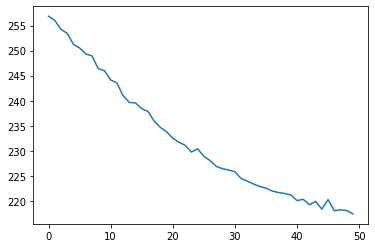

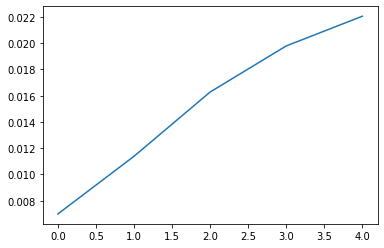

In [24]:
# train embed model
model = train_embed(best_params)

def objective(trial):
    #gamma = trial.suggest_loguniform('gamma', 1e-6, 1e-3)
    #lin_model = trial.suggest_categorical('lin_model', ['lasso', 'elastic'])
    #slim = train_SLIM(lin_model, gamma)
    
    alpha = trial.suggest_uniform('alpha', 0, 1)
    beta = trial.suggest_uniform('beta', 0, 0.5)
    
    ranking_mat = get_ranking_mat(model, alpha, beta)
    score = topn_precision(ranking_mat, user_items_test_dict)
    return -1 * score

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=2)

In [17]:
df = study.trials_dataframe() # pandasのDataFrame形式
df.to_csv('./hyparams_result.csv')

0.005572710458254794


In [ ]:
# save best params 
with open('best_param.pickle', 'wb') as f:
    pickle.dump(study.best_params, f)